# Files and imports

In [1]:
from pandas import read_csv, DataFrame, Series
import pandas as pd
from functools import reduce
import os
print(os.getcwd())

/Users/cozmaeug/Private/IST PG - DS/DaSH ENG/ist_dash_2024_rec/time_series_forecasting/notebooks/dataset_2_store_sales


In [2]:
# Define the path to your CSV file
filepath = "/Users/cozmaeug/Private/IST PG - DS/DaSH ENG/ist_dash_2024_rec/time_series_forecasting/notebooks/dataset_2_store_sales/dataset_2_store_sales/dataset/train.csv"

data = pd.read_csv(filepath)
file_tag = "Ecuadorian Store Sales"

print(data.head())  

         date  sales  onpromotion      date.1
0  2013-01-06    0.0            0  2013-01-06
1  2013-01-21    0.0            0  2013-01-21
2  2013-01-17    5.0            0  2013-01-17
3  2013-01-20    6.0            0  2013-01-20
4  2013-01-05    0.0            0  2013-01-05


In [3]:
data = data.drop(columns=["date.1"])
print(data.head())  

         date  sales  onpromotion
0  2013-01-06    0.0            0
1  2013-01-21    0.0            0
2  2013-01-17    5.0            0
3  2013-01-20    6.0            0
4  2013-01-05    0.0            0


In [4]:
%run 'scripts/dslabs_functions.py'

In [5]:
data.set_index('date', inplace=True)

# Scaling

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

yvalues sample: [0.0, 0.0, 5.0, 6.0, 0.0]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


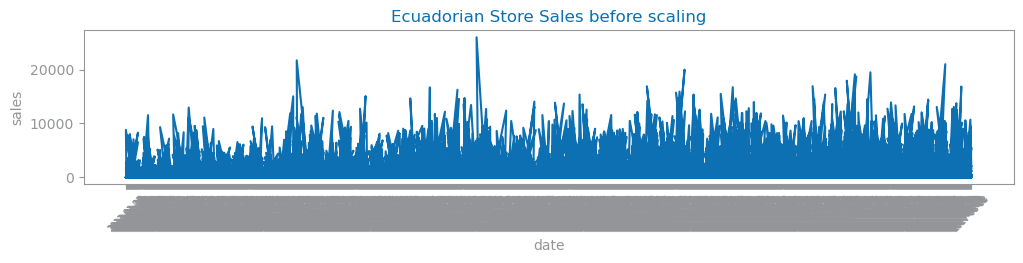

In [7]:
target = "sales"
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} before scaling",
)
show()

yvalues sample: [-0.3282379791874698, -0.3282379791874698, -0.32364463920157616, -0.3227259712043974, -0.3282379791874698]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


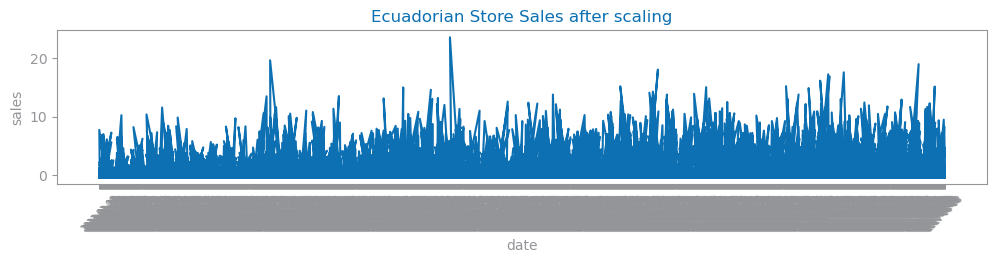

In [8]:
series_scaled: DataFrame = scale_all_dataframe(data)
series_scaled: Series = series_scaled[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_scaled.index.to_list(),
    series_scaled.to_list(),
    xlabel=series_scaled.index.name,
    ylabel=target,
    title=f"{file_tag} after scaling",
)
show()

## Evaluate

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

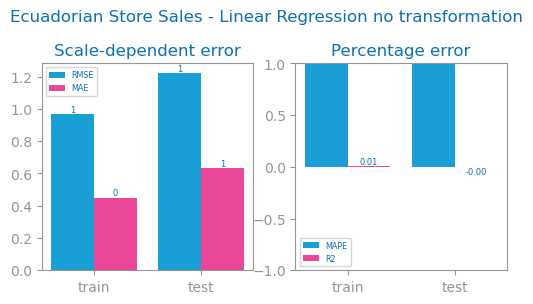

In [9]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import savefig
import pandas as pd
from numpy import arange
series_scaled = series_scaled.sort_index()

train, test = series_train_test_split(series_scaled, trn_pct=0.90)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(series_scaled)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression no transformation")

# Aggregation
Aggregation is just the operation of grouping smaller details into a coarser one, most similar to the approach we took in the profiling step.

In order to do it, we just need to apply the previous function - ts_aggregation_by, already available in the dslabs_functions file, that receives the univariate series to transform, the granularity level to aggregate into - gran_level, and the aggregation function to apply - agg_func.

In [10]:
def ts_aggregation_by(
    data: Series | DataFrame,
    gran_level: str = "D",
    agg_func: str = "mean",
) -> Series | DataFrame:
    # Make sure the index is a DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    df: Series | DataFrame = data.copy()
    index: Index[Period] = df.index.to_period(gran_level)  # Convert to PeriodIndex based on granularity
    df = df.groupby(by=index, dropna=True, sort=True).agg(agg_func)
    
    # Optional: Drop duplicates in the index if needed
    df.index = df.index.to_timestamp()  # Convert PeriodIndex back to DatetimeIndex
    
    return df


yvalues sample: [-0.3282379791874698, -0.3282379791874698, -0.3282379791874698, -0.3282379791874698, -0.3282379791874698]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
yvalues sample: [240.25445282084692, 245.49074809651475, 185.69724000000002, 134.9647188918919, 261.59930536132316]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


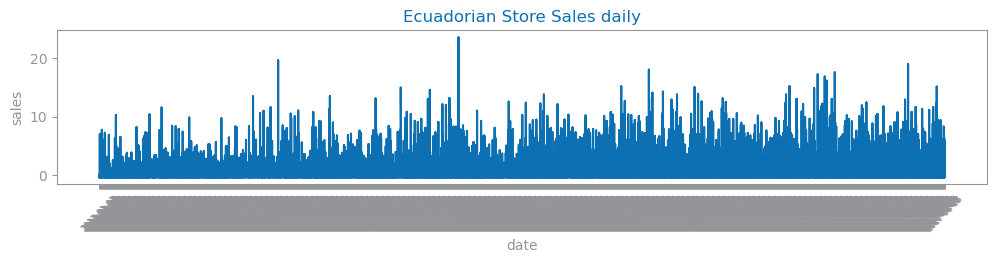

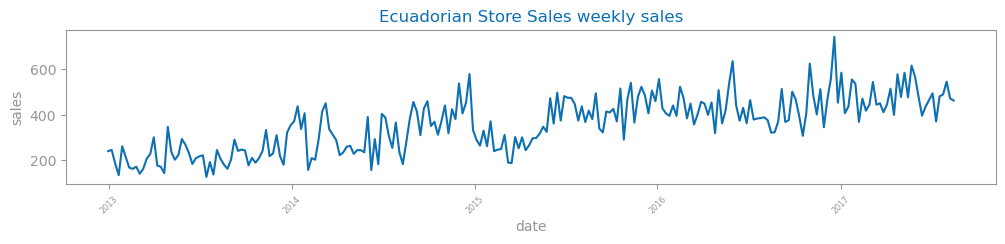

In [11]:
#series: Series = data[target]
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_scaled.index.to_list(),
    series_scaled.to_list(),
    xlabel=series_scaled.index.name,
    ylabel=target,
    title=f"{file_tag} daily",
)

series_scaled_agg_w: Series = ts_aggregation_by(series, gran_level="w", agg_func="mean")
series_scaled_agg_w.index = pd.to_datetime(series_scaled_agg_w.index)

series_scaled_agg_d: Series = ts_aggregation_by(series, gran_level="d", agg_func="mean")
series_scaled_agg_d.index = pd.to_datetime(series_scaled_agg_d.index)

series_scaled_agg_m: Series = ts_aggregation_by(series, gran_level="m", agg_func="mean")
series_scaled_agg_m.index = pd.to_datetime(series_scaled_agg_m.index)

series_scaled_agg_q: Series = ts_aggregation_by(series, gran_level="q", agg_func="mean")
series_scaled_agg_q.index = pd.to_datetime(series_scaled_agg_q.index)

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_scaled_agg_w.index.to_list(),
    series_scaled_agg_w.to_list(),
    xlabel=series_scaled_agg_w.index.name,
    ylabel=target,
    title=f"{file_tag} weekly {target}",
)
show()

## Evaluate 

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

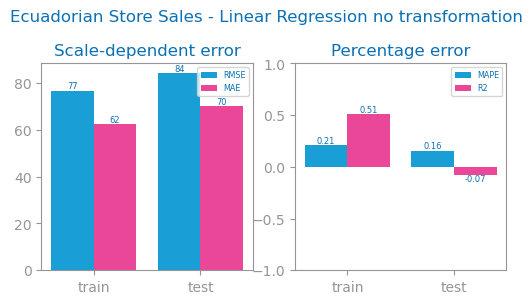

In [12]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import savefig
import pandas as pd
from numpy import arange
series_scaled_agg_w = series_scaled_agg_w.sort_index()

train, test = series_train_test_split(series_scaled_agg_w, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(series_scaled_agg_w)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression no transformation")

# Differentiation
- First differentiation removes trends (e.g., converts increasing values into stationary changes).
- Second differentiation removes linear trends (useful if first differentiation still shows patterns).
- Third differentiation is rare but can be used for very strong trends


yvalues sample: [5.236295275667828, -59.79350809651473, -50.73252110810813, 126.63458646943127, -46.673064371685854]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


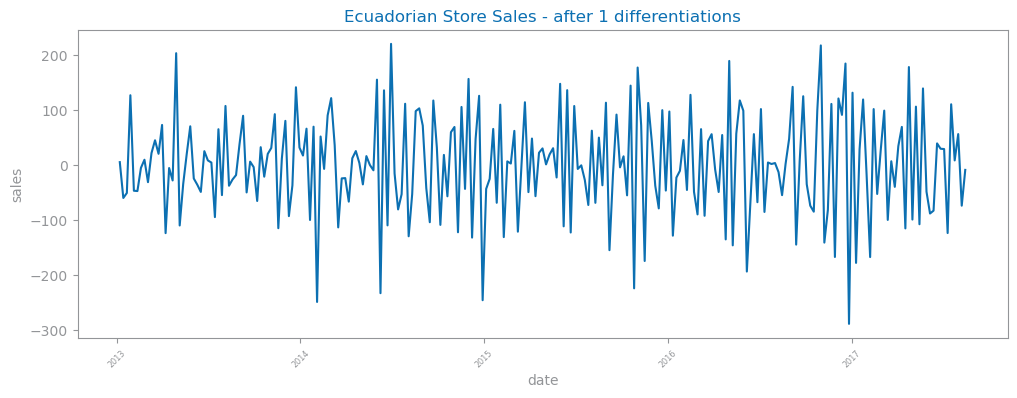

In [13]:
# Function to differentiate multiple times
def differentiate_series(series, n):
    for _ in range(n):
        series = series.diff().dropna()  # Differentiation and dropping NaNs
    return series

# Apply multiple differentiations
n_diff = 1  # Number of times to differentiate (e.g., 3 times)
series_scaled_diff = differentiate_series(series_scaled_agg_w, n_diff)

# Plot the result after differentiation
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series_scaled_diff.index.to_list(),
    series_scaled_diff.to_list(),
    title=f"{file_tag} - after {n_diff} differentiations",
    xlabel=series_scaled_diff.index.name,
    ylabel=target,
)
show()

## Evaluate 

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

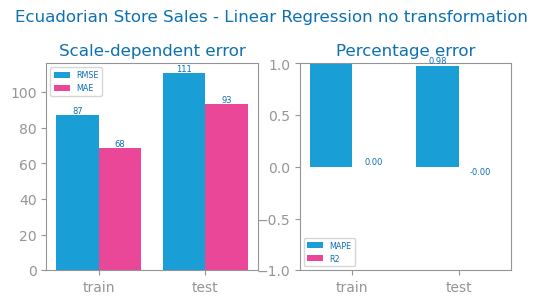

In [14]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import savefig
import pandas as pd
from numpy import arange
series_scaled_diff = series_scaled_diff.sort_index()
series_scaled_diff = series_scaled_diff.dropna()

train, test = series_train_test_split(series_scaled_diff, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(series_scaled_diff)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression no transformation")

# Smoothing
Não aplicar no conjunto de teste

yvalues sample: [nan, nan, nan, nan, nan]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
yvalues sample: [nan, nan, nan, nan, nan]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
yvalues sample: [nan, nan, nan, nan, nan]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
yvalues sample: [nan, nan, nan, nan, nan]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


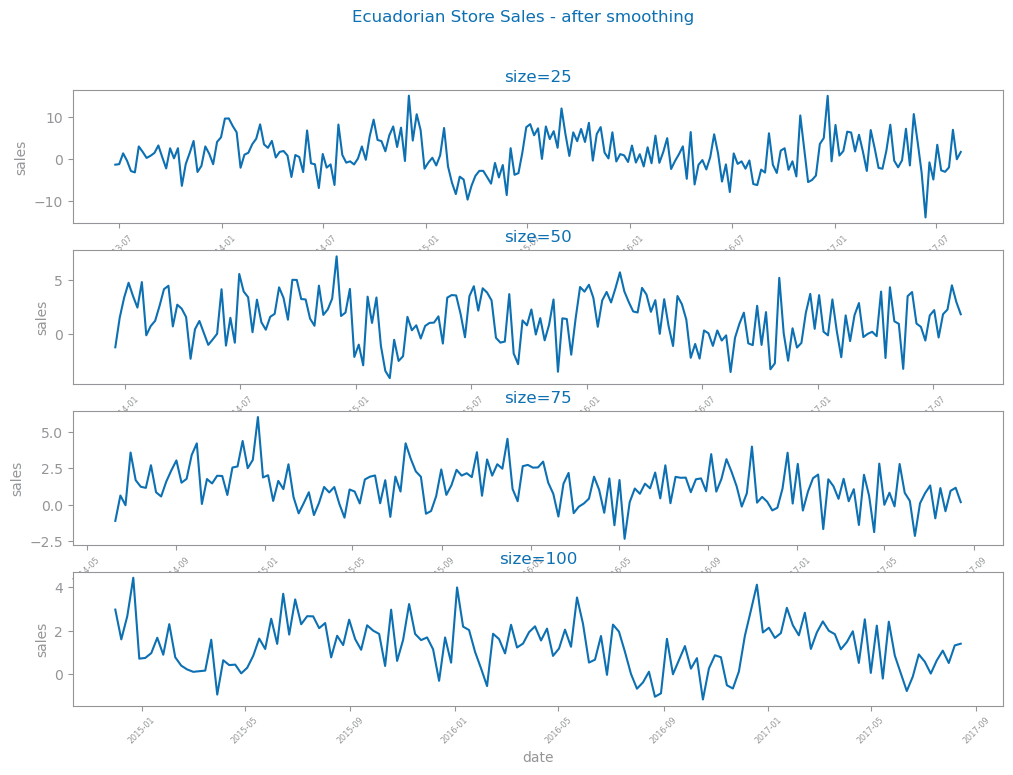

In [15]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure

sizes: list[int] = [25, 50, 75, 100]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(sizes), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(sizes)))
fig.suptitle(f"{file_tag} - after smoothing")

for i in range(len(sizes)):
    ss_smooth: Series = series_scaled_diff.rolling(window=sizes[i]).mean()
    plot_line_chart(
        ss_smooth.index.to_list(),
        ss_smooth.to_list(),
        ax=axs[i],
        xlabel=ss_smooth.index.name,
        ylabel=target,
        title=f"size={sizes[i]}",
    )
show()

## Evaluate

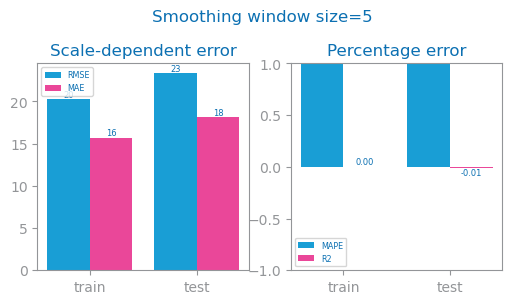

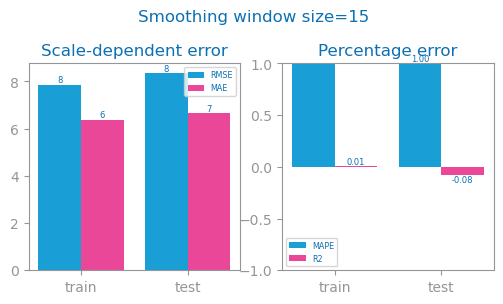

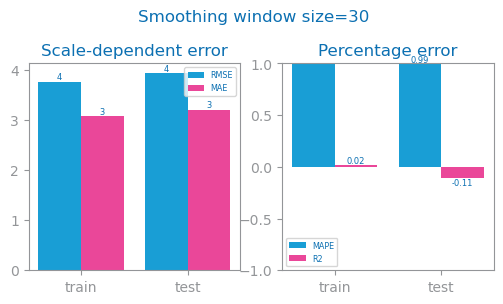

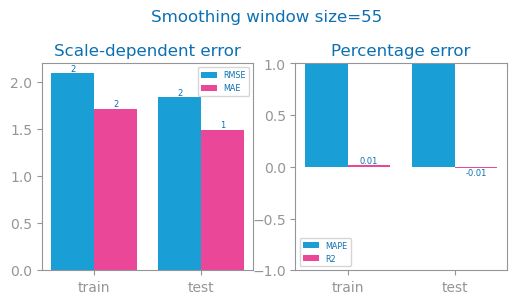

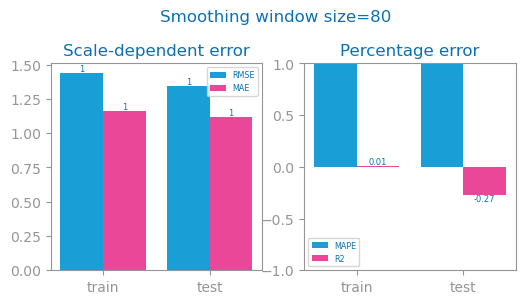

In [16]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import subplots
import numpy as np

sizes: list[int] = [5, 15, 30, 55, 80]

# Create a LinearRegression model
model = LinearRegression()

# Loop over each smoothing size and evaluate
ev1 = {"RMSE": [], "MAE": []}
ev2 = {"MAPE": [], "R2": []}

for i in range(len(sizes)):
    # Apply rolling mean smoothing
    ss_smooth: Series = series_scaled_diff.rolling(window=sizes[i]).mean().dropna()

    # Split into train/test sets (using 80-20 split)
    train, test = series_train_test_split(ss_smooth, trn_pct=0.80)
    
    trnX = np.arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = np.arange(len(train), len(ss_smooth)).reshape(-1, 1)
    tstY = test.to_numpy()

    # Train the model
    model.fit(trnX, trnY)
    
    # Make predictions
    prd_trn = model.predict(trnX)
    prd_tst = model.predict(tstX)

    # Use your existing evaluation function for train and test predictions
    plot_forecasting_eval(train, test, pd.Series(prd_trn, index=train.index), pd.Series(prd_tst, index=test.index), title=f"Smoothing window size={sizes[i]}")

show()


dont apply to test data!!! to be done.

yvalues sample: [nan, nan, nan, nan, nan]
Types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


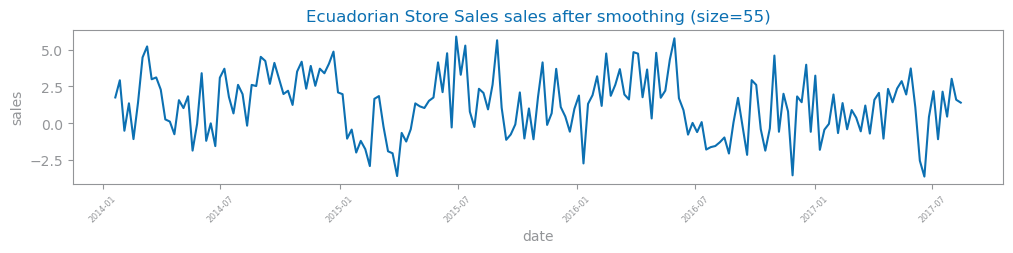

In [ ]:
WIN_SIZE = 55
ss_smooth: Series = series_scaled_diff.rolling(window=WIN_SIZE).mean()

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_smooth.index.to_list(),
    ss_smooth.to_list(),
    xlabel=ss_smooth.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after smoothing (size={WIN_SIZE})",
)
show()

# Evaluate with Lin Regression
Linear Regression models just assume that the time series follows a linear trend, and looks for the line that minimizes the sum of square errors. In order to implement it we just need to use the Linear Regressor sklearn class.

## Original, no transformation
* Low MAPE (< 10%): This indicates a good fit of your model (the predictions are close to the actual values).
* High MAPE (> 100%): This indicates a poor model, where predictions are significantly off from the true values.

If MAPE = 5%, the model's predictions are, on average, 5% off from the actual values.
If MAPE = 20%, predictions are off by 20% on average, which might not be reliable.


* R² = 1: The model perfectly predicts the data.
* R² = 0: The model's predictions are no better than simply predicting the mean of the target variable.
* R² < 0: The model is performing worse than just predicting the mean of the target variable.

If R² = 0.85, then 85% of the variance in the data is explained by your model.
If R² = 0.20, your model is not explaining much—it's likely not a good fit.

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

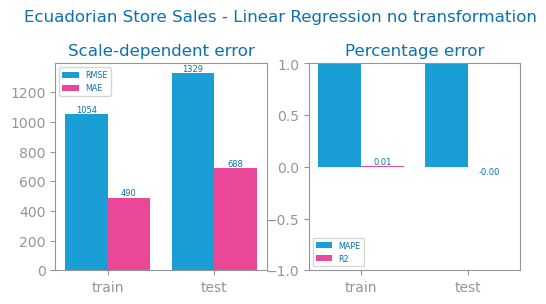

In [ ]:
train, test = series_train_test_split(data, trn_pct=0.90)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(data)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression no transformation")

<Axes: xlabel='date', ylabel='sales'>

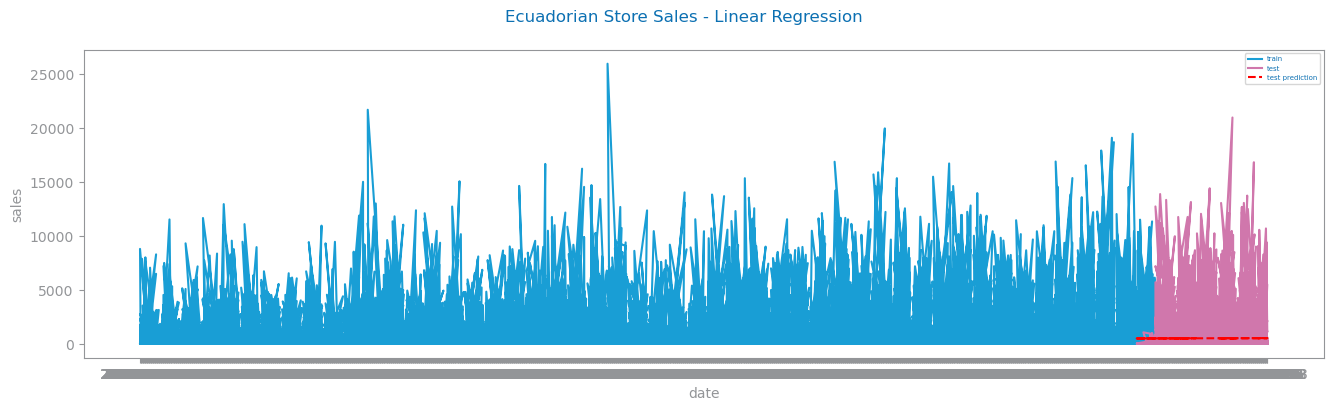

In [ ]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel="date",
    ylabel=target,
)